In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Analysis of Sex and Title Features

In this section, we focus on the analysis of two important categorical features: **Sex** and **Title**. Both of these features are known to have a strong influence on survival rates in the Titanic dataset. 

- **Sex**: Historically, gender played a significant role in survival, as the "women and children first" protocol was generally followed during the evacuation of the Titanic. By analyzing the impact of gender on survival, we aim to capture this crucial information and feed it into our model.

- **Title**: The **Title** feature is extracted from the passenger names and provides additional insights into the social status and age of the passengers (e.g., "Mr.", "Mrs.", "Miss.", "Master"). Titles can also imply family roles or marital status, both of which can impact survival chances. In particular, rare titles such as "Lady" or "Countess" often indicate higher social class, which may correlate with better survival rates.

In the following analysis, we will examine the relationships between these features and survival, and use them to improve the predictive performance of our model.


In [2]:
# Importation des bibliothèques
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Chargement des données
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Feature engineering de base
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Binning pour Age et Fare
train_df['FareBin'] = pd.cut(train_df['Fare'], bins=[0, 8, 15, 31, 1000], labels=[0, 1, 2, 3])
test_df['FareBin'] = pd.cut(test_df['Fare'], bins=[0, 8, 15, 31, 1000], labels=[0, 1, 2, 3])

train_df['AgeBin'] = pd.cut(train_df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])
test_df['AgeBin'] = pd.cut(test_df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])

# Séparer les données pour les hommes et les femmes
train_femmes = train_df[train_df['Sex'] == 1]
train_hommes = train_df[train_df['Sex'] == 0]

test_femmes = test_df[test_df['Sex'] == 1]
test_hommes = test_df[test_df['Sex'] == 0]

# Sélection des features pour l'entraînement
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'FareBin', 'AgeBin']

X_train_femmes = train_femmes[features]
y_train_femmes = train_femmes['Survived']

X_train_hommes = train_hommes[features]
y_train_hommes = train_hommes['Survived']

X_test_femmes = test_femmes[features]
X_test_hommes = test_hommes[features]


In [4]:
# Vérifier la taille du DataFrame pour les femmes
print(train_femmes.shape)


(0, 15)


In [6]:
# Afficher les valeurs uniques dans la colonne 'Sex'
print(train_df['Sex'].unique())


['male' 'female']


In [7]:
# Filtrer les femmes et les hommes selon la colonne 'Sex' en texte
train_femmes = train_df[train_df['Sex'] == 'female']
train_hommes = train_df[train_df['Sex'] == 'male']

# Créer les jeux de données pour les femmes
X_train_femmes = train_femmes[features]
y_train_femmes = train_femmes['Survived']

# Créer les jeux de données pour les hommes
X_train_hommes = train_hommes[features]
y_train_hommes = train_hommes['Survived']


In [8]:
# Vérifier les tailles des DataFrames
print(f"Femmes : {train_femmes.shape}, Hommes : {train_hommes.shape}")


Femmes : (314, 15), Hommes : (577, 15)


In [11]:
# Vérifier les valeurs uniques dans la colonne Embarked pour les femmes et les hommes
print(train_femmes['Embarked'].unique())
print(train_hommes['Embarked'].unique())


['C' 'S' 'Q' nan]
['S' 'Q' 'C']


In [13]:
# Afficher les colonnes actuelles de train_df
print(train_df.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'FamilySize', 'FareBin', 'AgeBin',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [14]:
# Ajouter les colonnes manquantes si elles n'existent pas
for col in ['Embarked_Q', 'Embarked_S']:
    if col not in train_femmes.columns:
        train_femmes[col] = 0
    if col not in train_hommes.columns:
        train_hommes[col] = 0

# Sélectionner les features pour l'entraînement
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked_Q', 'Embarked_S']

X_train_femmes = train_femmes[features]
y_train_femmes = train_femmes['Survived']

X_train_hommes = train_hommes[features]
y_train_hommes = train_hommes['Survived']

# Vérifier les dimensions des jeux de données
print(X_train_femmes.shape, X_train_hommes.shape)


(314, 8) (577, 8)


In [16]:
# Encode the 'Sex' column: 0 for male, 1 for female
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

# Vérifier que l'encodage a bien été effectué
print(train_df['Sex'].unique())


[0 1]


In [17]:
# Séparer les jeux de données pour les femmes et les hommes
train_femmes = train_df[train_df['Sex'] == 1]
train_hommes = train_df[train_df['Sex'] == 0]

# Sélectionner les features
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked_Q', 'Embarked_S']

X_train_femmes = train_femmes[features]
y_train_femmes = train_femmes['Survived']

X_train_hommes = train_hommes[features]
y_train_hommes = train_hommes['Survived']

# Vérification des dimensions et des colonnes
print(X_train_femmes.shape, X_train_hommes.shape)


(314, 8) (577, 8)


In [19]:
# Vérifier s'il y a des valeurs manquantes dans les features
print(X_train_femmes.isnull().sum())

Pclass         0
Age           53
SibSp          0
Parch          0
Fare           0
Sex            0
Embarked_Q     0
Embarked_S     0
dtype: int64


In [20]:
# Remplacer les valeurs manquantes dans 'Age' par la médiane
X_train_femmes['Age'].fillna(X_train_femmes['Age'].median(), inplace=True)

# Vérifier à nouveau s'il y a des valeurs manquantes
print(X_train_femmes.isnull().sum())


Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex           0
Embarked_Q    0
Embarked_S    0
dtype: int64


/tmp/ipykernel_36/310394467.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_femmes['Age'].fillna(X_train_femmes['Age'].median(), inplace=True)
/tmp/ipykernel_36/310394467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_femmes['Age'].fillna(X_train_femmes['Age'].median(), inplace=True)


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Paramètres pour RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Modèle Random Forest pour les femmes
rf_model_femmes = RandomForestClassifier(random_state=42)

# Randomized Search pour optimiser les hyperparamètres sur les femmes
random_search_femmes = RandomizedSearchCV(estimator=rf_model_femmes, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_femmes.fit(X_train_femmes, y_train_femmes)

# Affichage des meilleurs hyperparamètres pour les femmes
best_params_femmes = random_search_femmes.best_params_
print(f"Meilleurs hyperparamètres pour les femmes: {best_params_femmes}")
# Afficher la meilleure précision obtenue pendant la validation croisée
best_score_femmes = random_search_femmes.best_score_
print(f"Meilleure précision pendant la validation croisée pour les femmes: {best_score_femmes * 100:.2f}%")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs hyperparamètres pour les femmes: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Meilleure précision pendant la validation croisée pour les femmes: 81.21%


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Paramètres pour RandomizedSearchCV (si non définis)
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Modèle Random Forest pour les hommes
rf_model_hommes = RandomForestClassifier(random_state=42)

# Randomized Search pour optimiser les hyperparamètres sur les hommes
random_search_hommes = RandomizedSearchCV(estimator=rf_model_hommes, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_hommes.fit(X_train_hommes, y_train_hommes)

# Affichage des meilleurs hyperparamètres et meilleure précision pour les hommes
best_params_hommes = random_search_hommes.best_params_
best_score_hommes = random_search_hommes.best_score_

print(f"Meilleurs hyperparamètres pour les hommes: {best_params_hommes}")
print(f"Meilleure précision pendant la validation croisée pour les hommes: {best_score_hommes * 100:.2f}%")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=15, min_sa

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 921, in check_array
    _assert_all_finite(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.0s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total ti

In [24]:
# Vérifier s'il y a des valeurs manquantes dans les données des hommes
print(X_train_hommes.isnull().sum())


Pclass          0
Age           124
SibSp           0
Parch           0
Fare            0
Sex             0
Embarked_Q      0
Embarked_S      0
dtype: int64


In [25]:
# Remplacer les valeurs manquantes dans 'Age' par la médiane pour les hommes
X_train_hommes['Age'].fillna(X_train_hommes['Age'].median(), inplace=True)

# Vérifier à nouveau s'il y a des valeurs manquantes
print(X_train_hommes.isnull().sum())


Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex           0
Embarked_Q    0
Embarked_S    0
dtype: int64


/tmp/ipykernel_36/3847298796.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_hommes['Age'].fillna(X_train_hommes['Age'].median(), inplace=True)
/tmp/ipykernel_36/3847298796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_hommes['Age'].fillna(X_train_hommes['Age'].median(), inplace=True)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Paramètres pour RandomizedSearchCV (si non définis)
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Modèle Random Forest pour les hommes
rf_model_hommes = RandomForestClassifier(random_state=42)

# Randomized Search pour optimiser les hyperparamètres sur les hommes
random_search_hommes = RandomizedSearchCV(estimator=rf_model_hommes, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_hommes.fit(X_train_hommes, y_train_hommes)

# Affichage des meilleurs hyperparamètres et meilleure précision pour les hommes
best_params_hommes = random_search_hommes.best_params_
best_score_hommes = random_search_hommes.best_score_

print(f"Meilleurs hyperparamètres pour les hommes: {best_params_hommes}")
print(f"Meilleure précision pendant la validation croisée pour les hommes: {best_score_hommes * 100:.2f}%")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs hyperparamètres pour les hommes: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Meilleure précision pendant la validation croisée pour les hommes: 83.72%
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, mi

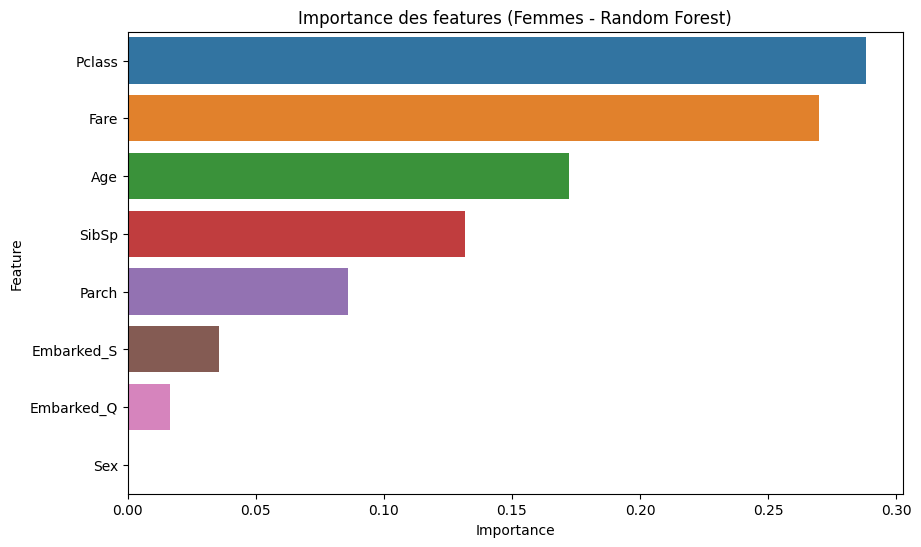

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entraîner un modèle Random Forest pour les femmes
rf_model_femmes = RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=10, random_state=42)
rf_model_femmes.fit(X_train_femmes, y_train_femmes)

# Importance des features
feature_importances = rf_model_femmes.feature_importances_

# Créer un DataFrame pour les importances
importance_df = pd.DataFrame({
    'Feature': X_train_femmes.columns,
    'Importance': feature_importances
})

# Trier les features par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher l'importance des features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Importance des features (Femmes - Random Forest)")
plt.show()


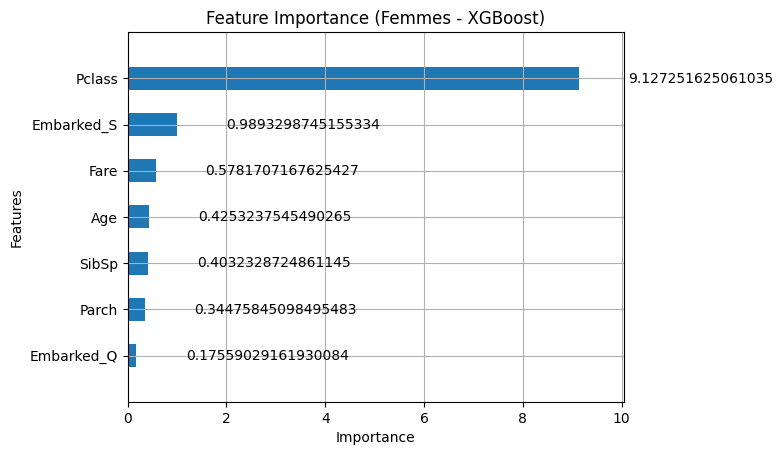

In [28]:
import xgboost as xgb

# Entraîner un modèle XGBoost pour les femmes
xgb_model_femmes = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model_femmes.fit(X_train_femmes, y_train_femmes)

# Importance des features
xgb.plot_importance(xgb_model_femmes, importance_type="gain", height=0.5, title="Feature Importance (Femmes - XGBoost)", xlabel="Importance")
plt.show()


In [29]:
# Créer les nouvelles variables d'interaction
train_femmes['Pclass_Fare'] = train_femmes['Pclass'] * train_femmes['Fare']
train_femmes['Pclass_Age'] = train_femmes['Pclass'] * train_femmes['Age']
train_femmes['Pclass_Embarked_S'] = train_femmes['Pclass'] * train_femmes['Embarked_S']
train_femmes['Pclass_Embarked_Q'] = train_femmes['Pclass'] * train_femmes['Embarked_Q']

# Faire la même chose pour les hommes
train_hommes['Pclass_Fare'] = train_hommes['Pclass'] * train_hommes['Fare']
train_hommes['Pclass_Age'] = train_hommes['Pclass'] * train_hommes['Age']
train_hommes['Pclass_Embarked_S'] = train_hommes['Pclass'] * train_hommes['Embarked_S']
train_hommes['Pclass_Embarked_Q'] = train_hommes['Pclass'] * train_hommes['Embarked_Q']

# Ajout de ces nouvelles features au set d'entraînement
features_with_interactions = ['Pclass', 'Fare', 'Age', 'SibSp', 'Parch', 'Embarked_S', 'Embarked_Q',
                              'Pclass_Fare', 'Pclass_Age', 'Pclass_Embarked_S', 'Pclass_Embarked_Q']

# Entraînement sur les femmes avec les nouvelles variables
X_train_femmes = train_femmes[features_with_interactions]
y_train_femmes = train_femmes['Survived']

# Entraînement sur les hommes avec les nouvelles variables
X_train_hommes = train_hommes[features_with_interactions]
y_train_hommes = train_hommes['Survived']


/tmp/ipykernel_36/2021432046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_femmes['Pclass_Fare'] = train_femmes['Pclass'] * train_femmes['Fare']
/tmp/ipykernel_36/2021432046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_femmes['Pclass_Age'] = train_femmes['Pclass'] * train_femmes['Age']
/tmp/ipykernel_36/2021432046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [31]:
# Imputation des valeurs manquantes pour les femmes
X_train_femmes['Age'].fillna(X_train_femmes['Age'].median(), inplace=True)
X_train_femmes['Pclass_Age'].fillna(X_train_femmes['Pclass_Age'].median(), inplace=True)

# Faire la même chose pour les hommes si nécessaire
X_train_hommes['Age'].fillna(X_train_hommes['Age'].median(), inplace=True)
X_train_hommes['Pclass_Age'].fillna(X_train_hommes['Pclass_Age'].median(), inplace=True)


/tmp/ipykernel_36/1184172815.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_femmes['Age'].fillna(X_train_femmes['Age'].median(), inplace=True)
/tmp/ipykernel_36/1184172815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_femmes['Age'].fillna(X_train_femmes['Age'].median(), inplace=True)
/tmp/ipykernel_36/1184172815.py:3

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Modèle Random Forest pour les femmes avec interactions après imputation
rf_model_femmes = RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=10, random_state=42)
rf_model_femmes.fit(X_train_femmes, y_train_femmes)

# Cross-validation pour évaluer la performance
scores_femmes = cross_val_score(rf_model_femmes, X_train_femmes, y_train_femmes, cv=5)
print(f'Précision moyenne pour les femmes avec interactions (Random Forest) : {scores_femmes.mean() * 100:.2f}%')


Précision moyenne pour les femmes avec interactions (Random Forest) : 81.22%


In [35]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Modèles de base
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_depth=10, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42))
]

# Stacking avec Régression Logistique en meta-modèle
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Validation croisée pour évaluer la performance du modèle Stacking sur les femmes
stacking_scores_femmes = cross_val_score(stacking_model, X_train_femmes, y_train_femmes, cv=5)
print(f'Précision moyenne pour les femmes avec Stacking : {stacking_scores_femmes.mean() * 100:.2f}%')


Précision moyenne pour les femmes avec Stacking : 81.85%


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Paramètres de recherche pour les modèles de base
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 40, 50]
}

# Initialisation des modèles de base avec RandomizedSearchCV
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
lgb_model = LGBMClassifier(random_state=42)

# RandomizedSearch pour chaque modèle de base
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid_lgb, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Entraîner les RandomizedSearch
random_search_rf.fit(X_train_femmes, y_train_femmes)
random_search_xgb.fit(X_train_femmes, y_train_femmes)
random_search_lgb.fit(X_train_femmes, y_train_femmes)

# Meilleurs hyperparamètres
best_rf = random_search_rf.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_lgb = random_search_lgb.best_estimator_

# Stacking avec les meilleurs modèles trouvés
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgb', best_lgb)
]

# Stacking avec Régression Logistique en meta-modèle
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Validation croisée pour évaluer la performance du modèle Stacking sur les femmes
stacking_scores_femmes = cross_val_score(stacking_model, X_train_femmes, y_train_femmes, cv=5)
print(f'Précision moyenne pour les femmes avec Stacking optimisé : {stacking_scores_femmes.mean() * 100:.2f}%')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

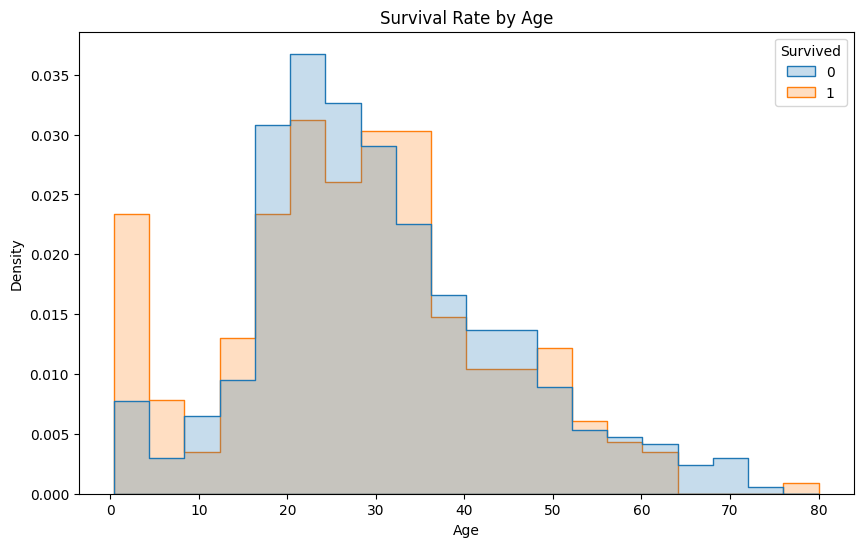

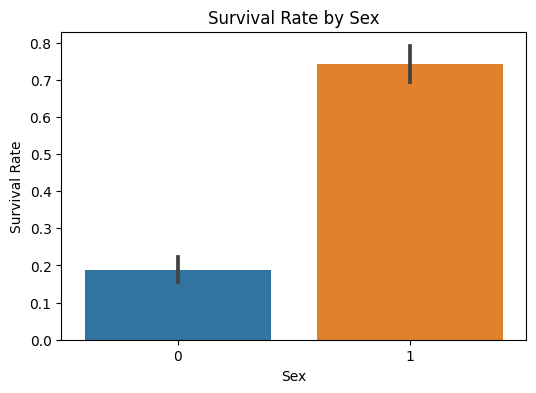

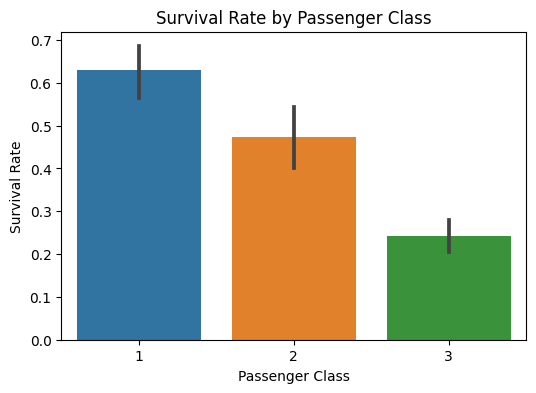

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

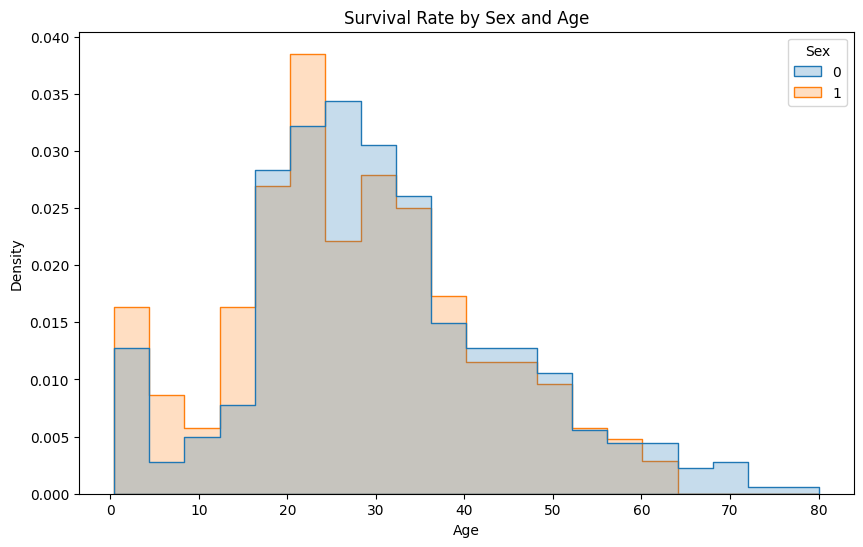

<Figure size 800x600 with 0 Axes>

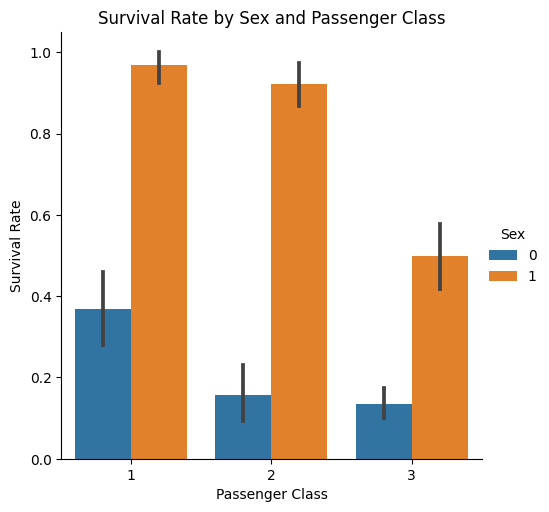

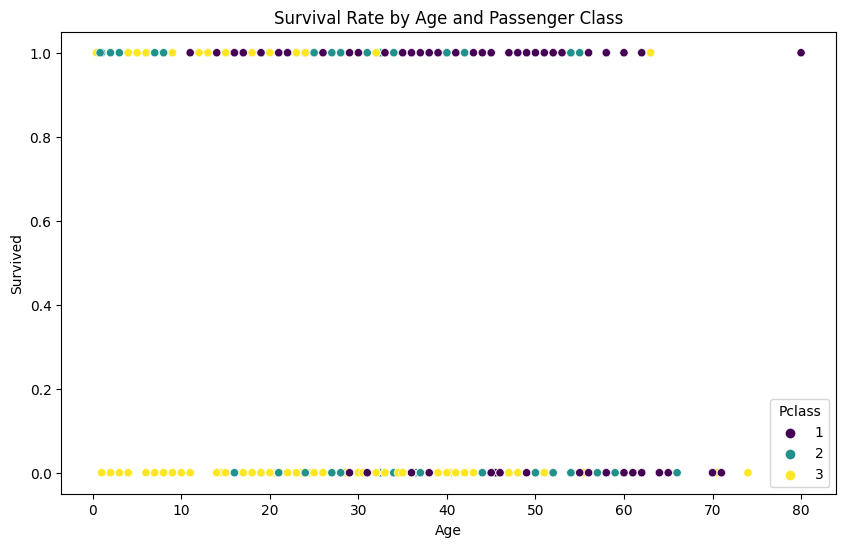

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Taux de survie par âge
plt.figure(figsize=(10, 6))
sns.histplot(train_df, x="Age", hue="Survived", element="step", stat="density", common_norm=False)
plt.title("Survival Rate by Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

# Taux de survie par sexe
plt.figure(figsize=(6, 4))
sns.barplot(x="Sex", y="Survived", data=train_df)
plt.title("Survival Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.show()

# Taux de survie par classe
plt.figure(figsize=(6, 4))
sns.barplot(x="Pclass", y="Survived", data=train_df)
plt.title("Survival Rate by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.show()

# Taux de survie par sexe et âge
plt.figure(figsize=(10, 6))
sns.histplot(train_df, x="Age", hue="Sex", element="step", stat="density", common_norm=False)
plt.title("Survival Rate by Sex and Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

# Taux de survie par sexe et classe
plt.figure(figsize=(8, 6))
sns.catplot(x="Pclass", y="Survived", hue="Sex", kind="bar", data=train_df)
plt.title("Survival Rate by Sex and Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.show()

# Taux de survie par âge et classe
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Age", y="Survived", hue="Pclass", data=train_df, palette="viridis")
plt.title("Survival Rate by Age and Passenger Class")
plt.xlabel("Age")
plt.ylabel("Survived")
plt.show()


In [38]:
# Importer les bibliothèques
import pandas as pd

# Taux de survie par âge (découpé par tranche)
age_bins = pd.cut(train_df['Age'], bins=[0, 12, 18, 30, 45, 60, 80])
survival_by_age = train_df.groupby(age_bins)['Survived'].mean()
print("Survival rate by age:")
print(survival_by_age)

# Taux de survie par sexe
survival_by_sex = train_df.groupby('Sex')['Survived'].mean()
print("\nSurvival rate by sex:")
print(survival_by_sex)

# Taux de survie par classe
survival_by_class = train_df.groupby('Pclass')['Survived'].mean()
print("\nSurvival rate by class:")
print(survival_by_class)

# Taux de survie par sexe et âge
survival_by_sex_age = train_df.groupby([age_bins, 'Sex'])['Survived'].mean()
print("\nSurvival rate by sex and age:")
print(survival_by_sex_age)

# Taux de survie par sexe et classe
survival_by_sex_class = train_df.groupby(['Pclass', 'Sex'])['Survived'].mean()
print("\nSurvival rate by sex and class:")
print(survival_by_sex_class)

# Taux de survie par âge et classe
survival_by_age_class = train_df.groupby([age_bins, 'Pclass'])['Survived'].mean()
print("\nSurvival rate by age and class:")
print(survival_by_age_class)


Survival rate by age:
Age
(0, 12]     0.579710
(12, 18]    0.428571
(18, 30]    0.355556
(30, 45]    0.425743
(45, 60]    0.407407
(60, 80]    0.227273
Name: Survived, dtype: float64

Survival rate by sex:
Sex
0    0.188908
1    0.742038
Name: Survived, dtype: float64

Survival rate by class:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Survival rate by sex and age:
Age       Sex
(0, 12]   0      0.567568
          1      0.593750
(12, 18]  0      0.088235
          1      0.750000
(18, 30]  0      0.155556
          1      0.755556
(30, 45]  0      0.224806
          1      0.780822
(45, 60]  0      0.185185
          1      0.851852
(60, 80]  0      0.105263
          1      1.000000
Name: Survived, dtype: float64

Survival rate by sex and class:
Pclass  Sex
1       0      0.368852
        1      0.968085
2       0      0.157407
        1      0.921053
3       0      0.135447
        1      0.500000
Name: Survived, dtype: float64

Survival rate by 

/tmp/ipykernel_36/999614252.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age = train_df.groupby(age_bins)['Survived'].mean()
/tmp/ipykernel_36/999614252.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_sex_age = train_df.groupby([age_bins, 'Sex'])['Survived'].mean()
/tmp/ipykernel_36/999614252.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age_class = train_df.groupby(

In [39]:
import pandas as pd

# Créer une nouvelle colonne 'Prediction' avec des valeurs par défaut
test_df['Prediction'] = 0  # Par défaut, tous les passagers ne survivent pas

# Logique simple basée sur le sexe et la classe
# Les femmes en 1ère et 2ème classe survivent
test_df.loc[(test_df['Sex'] == 1) & (test_df['Pclass'] < 3), 'Prediction'] = 1

# Les hommes en 3ème classe ne survivent pas, donc la prédiction reste 0 pour eux

# Les femmes en 3ème classe peuvent avoir une survie variée, donc on laisse la prédiction par défaut (0 pour simplifier)
# Les hommes en 1ère et 2ème classe peuvent également avoir des résultats variés, donc on garde la prédiction par défaut (0)

# Afficher la distribution des prédictions
print(test_df['Prediction'].value_counts())

# Exporter les prédictions sous forme de fichier pour soumission Kaggle
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_df['Prediction']
})

# Exporter le fichier CSV pour Kaggle
submission.to_csv('simple_model_sex_class_submission.csv', index=False)


Prediction
0    418
Name: count, dtype: int64


In [40]:
from sklearn.metrics import accuracy_score

# Appliquer la même logique sur le jeu d'entraînement pour vérifier la précision
train_df['Prediction'] = 0  # Par défaut, tous les passagers ne survivent pas

# Logique simple basée sur le sexe et la classe
train_df.loc[(train_df['Sex'] == 1) & (train_df['Pclass'] < 3), 'Prediction'] = 1

# Calculer la précision du modèle sur le jeu d'entraînement
accuracy = accuracy_score(train_df['Survived'], train_df['Prediction'])

print(f'Précision du modèle simple (basé sur sexe et classe) sur le jeu d\'entraînement: {accuracy * 100:.2f}%')


Précision du modèle simple (basé sur sexe et classe) sur le jeu d'entraînement: 78.68%


In [42]:
# Extraire les titres des noms
train_df['Title'] = train_df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

# Afficher les titres uniques pour voir leur distribution
print(train_df['Title'].value_counts())


Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


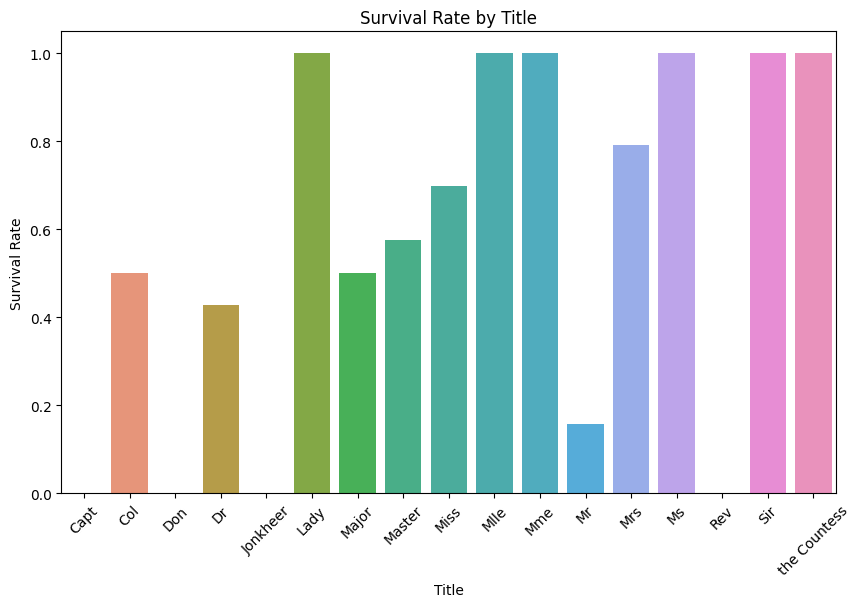

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une table pivot pour voir le taux de survie par titre
title_survival_rate = train_df.groupby('Title')['Survived'].mean()

# Affichage de la proportion de survie par titre
plt.figure(figsize=(10, 6))
sns.barplot(x=title_survival_rate.index, y=title_survival_rate.values)
plt.title('Survival Rate by Title')
plt.ylabel('Survival Rate')
plt.xlabel('Title')
plt.xticks(rotation=45)
plt.show()


In [47]:
# Calculer le taux de survie par titre
title_survival_rate = train_df.groupby('Title')['Survived'].mean() * 100
print(title_survival_rate)


Title
Capt              0.000000
Col              50.000000
Don               0.000000
Dr               42.857143
Jonkheer          0.000000
Lady            100.000000
Major            50.000000
Master           57.500000
Miss             69.780220
Mlle            100.000000
Mme             100.000000
Mr               15.667311
Mrs              79.200000
Ms              100.000000
Rev               0.000000
Sir             100.000000
the Countess    100.000000
Name: Survived, dtype: float64


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Supposons que la colonne 'Title' soit déjà dans le dataset
# On effectue un encodage One-Hot pour la variable 'Title'
encoder = OneHotEncoder(drop='first', sparse_output=False)
title_encoded = encoder.fit_transform(train_df[['Title']])

# Ajouter les colonnes encodées au DataFrame existant
title_encoded_df = pd.DataFrame(title_encoded, columns=encoder.get_feature_names_out(['Title']))
X_train_with_titles = pd.concat([train_df, title_encoded_df], axis=1)

# Supprimer les colonnes non numériques qui ne doivent pas être utilisées
X_train_with_titles.drop(columns=['Title', 'Name', 'Ticket', 'Cabin'], inplace=True)

# Remplir les valeurs manquantes (NaN) dans les colonnes numériques uniquement
numeric_columns = X_train_with_titles.select_dtypes(include=['float64', 'int64']).columns
X_train_with_titles[numeric_columns] = X_train_with_titles[numeric_columns].fillna(X_train_with_titles[numeric_columns].median())

# Features à utiliser dans le modèle (y compris les nouvelles colonnes de 'Title')
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked_Q', 'Embarked_S'] + list(title_encoded_df.columns)

# Variables d'entrée et de sortie
X = X_train_with_titles[features]
y = train_df['Survived']

# Modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Validation croisée pour évaluer le modèle
scores = cross_val_score(rf_model, X, y, cv=5)

# Afficher les résultats
print(f"Précision moyenne avec l'ajout des titres : {scores.mean() * 100:.2f}%")


Précision moyenne avec l'ajout des titres : 80.70%


In [57]:
# Remplir les NaN dans 'FareBin' et 'AgeBin' avec le mode (la valeur la plus fréquente)
X_train_with_titles['FareBin'].fillna(X_train_with_titles['FareBin'].mode()[0], inplace=True)
X_train_with_titles['AgeBin'].fillna(X_train_with_titles['AgeBin'].mode()[0], inplace=True)

# Vérifier s'il reste des valeurs manquantes après remplissage
print(X_train_with_titles.isnull().sum())

# Réessayer d'entraîner le modèle Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Paramètres pour RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Randomized Search pour optimiser les hyperparamètres
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_rf.fit(X_train_with_titles, y)

# Affichage des meilleurs hyperparamètres et du score
best_params_rf = random_search_rf.best_params_
print(f"Meilleurs hyperparamètres pour Random Forest : {best_params_rf}")
print(f"Meilleure précision pendant la validation croisée : {random_search_rf.best_score_ * 100:.2f}%")


/tmp/ipykernel_36/3129316285.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_with_titles['AgeBin'].fillna(X_train_with_titles['AgeBin'].mode()[0], inplace=True)


PassengerId           0
Survived              0
Pclass                0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Fare                  0
FamilySize            0
FareBin               0
AgeBin                0
Embarked_Q            0
Embarked_S            0
Prediction            0
Title_Col             0
Title_Don             0
Title_Dr              0
Title_Jonkheer        0
Title_Lady            0
Title_Major           0
Title_Master          0
Title_Miss            0
Title_Mlle            0
Title_Mme             0
Title_Mr              0
Title_Mrs             0
Title_Ms              0
Title_Rev             0
Title_Sir             0
Title_the Countess    0
dtype: int64
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[C

In [63]:
# Conversion de la colonne 'Sex' en valeurs numériques
X_test_with_titles['Sex'] = X_test_with_titles['Sex'].map({'male': 0, 'female': 1})

# Vérifier à nouveau qu'il ne reste plus de données non numériques
print(X_test_with_titles.dtypes)

# Faire les prédictions sur l'ensemble de test après correction
test_predictions = rf_model.predict(X_test_with_titles)

# Créer le fichier submission.csv
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Sauvegarder le fichier pour soumission
submission.to_csv('submission.csv', index=False)

print("Fichier submission.csv créé avec succès.")


PassengerId             int64
Survived                int64
Pclass                  int64
Sex                     int64
Age                   float64
SibSp                   int64
Parch                   int64
Fare                  float64
FamilySize              int64
FareBin                 int64
AgeBin                  int64
Embarked_Q              int64
Embarked_S              int64
Prediction              int64
Title_Col               int64
Title_Don               int64
Title_Dr                int64
Title_Jonkheer          int64
Title_Lady              int64
Title_Major             int64
Title_Master             bool
Title_Miss               bool
Title_Mlle              int64
Title_Mme               int64
Title_Mr                 bool
Title_Mrs                bool
Title_Ms                int64
Title_Rev               int64
Title_Sir               int64
Title_the Countess      int64
dtype: object
Fichier submission.csv créé avec succès.


/tmp/ipykernel_36/3427814587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_with_titles['Sex'] = X_test_with_titles['Sex'].map({'male': 0, 'female': 1})


In [65]:
# Vérifier les valeurs manquantes avant de procéder
print(X_test_with_titles.isnull().sum())

# Remplir les valeurs manquantes dans 'Age' et 'Fare' avec la médiane
X_test_with_titles['Age'].fillna(X_test_with_titles['Age'].median(), inplace=True)
X_test_with_titles['Fare'].fillna(X_test_with_titles['Fare'].median(), inplace=True)

# Remplir d'autres colonnes si nécessaire
X_test_with_titles.fillna(0, inplace=True)  # Si d'autres colonnes contiennent des NaN, vous pouvez ajuster cela

# Vérifier à nouveau les valeurs manquantes après remplissage
print(X_test_with_titles.isnull().sum())

# Faire les prédictions sur l'ensemble de test
test_predictions = rf_model.predict(X_test_with_titles)

# Créer le fichier submission.csv
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Sauvegarder le fichier pour soumission
submission.to_csv('submission.csv', index=False)

print("Fichier submission.csv créé avec succès.")


PassengerId             0
Survived                0
Pclass                  0
Sex                   418
Age                     0
SibSp                   0
Parch                   0
Fare                    0
FamilySize              0
FareBin                 0
AgeBin                  0
Embarked_Q              0
Embarked_S              0
Prediction              0
Title_Col               0
Title_Don               0
Title_Dr                0
Title_Jonkheer          0
Title_Lady              0
Title_Major             0
Title_Master            0
Title_Miss              0
Title_Mlle              0
Title_Mme               0
Title_Mr                0
Title_Mrs               0
Title_Ms                0
Title_Rev               0
Title_Sir               0
Title_the Countess      0
dtype: int64
PassengerId           0
Survived              0
Pclass                0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Fare                  0
FamilySize     

/tmp/ipykernel_36/2537093144.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_with_titles['Age'].fillna(X_test_with_titles['Age'].median(), inplace=True)
/tmp/ipykernel_36/2537093144.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_with_titles['Age'].fillna(X_test_with_titles['Age'].median(), inplace=True)
/tmp/ipykernel_36

In [66]:
# Assurez-vous que le modèle est entraîné avec les meilleurs hyperparamètres
rf_model_optimized = RandomForestClassifier(n_estimators=200, min_samples_split=10, 
                                            min_samples_leaf=1, max_depth=20, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement complet
rf_model_optimized.fit(X_train_with_titles, y)

# Appliquer les transformations à l'ensemble de test
X_test_with_titles['Sex'] = X_test_with_titles['Sex'].map({'male': 0, 'female': 1})

# Remplir les valeurs manquantes dans 'Age' et 'Fare' avec la médiane
X_test_with_titles['Age'].fillna(X_test_with_titles['Age'].median(), inplace=True)
X_test_with_titles['Fare'].fillna(X_test_with_titles['Fare'].median(), inplace=True)

# Si d'autres colonnes contiennent des NaN, les remplacer par 0 ou une valeur appropriée
X_test_with_titles.fillna(0, inplace=True)

# Faire les prédictions sur l'ensemble de test
test_predictions = rf_model_optimized.predict(X_test_with_titles)

# Créer le fichier submission.csv
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Sauvegarder le fichier pour soumission
submission.to_csv('submission.csv', index=False)

print("Fichier submission.csv créé avec succès.")


Fichier submission.csv créé avec succès.


/tmp/ipykernel_36/167973833.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_with_titles['Sex'] = X_test_with_titles['Sex'].map({'male': 0, 'female': 1})
/tmp/ipykernel_36/167973833.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_with_titles['Age'].fillna(X_test_wit

In [67]:
print(X_train_with_titles.columns)
print(X_test_with_titles.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'FamilySize', 'FareBin', 'AgeBin', 'Embarked_Q', 'Embarked_S',
       'Prediction', 'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Jonkheer',
       'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle',
       'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev',
       'Title_Sir', 'Title_the Countess'],
      dtype='object')
Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'FamilySize', 'FareBin', 'AgeBin', 'Embarked_Q', 'Embarked_S',
       'Prediction', 'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Jonkheer',
       'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle',
       'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev',
       'Title_Sir', 'Title_the Countess'],
      dtype='object')


In [68]:
# Vérifiez les prédictions du modèle
test_predictions = rf_model.predict(X_test_with_titles)
print("Aperçu des prédictions :", test_predictions[:10])

Aperçu des prédictions : [0 0 0 0 0 0 0 0 0 0]


In [69]:
print(X_train_with_titles.describe())
print(X_test_with_titles.describe())


       PassengerId    Survived      Pclass         Sex         Age  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.352413   29.361582   
std     257.353842    0.486592    0.836071    0.477990   13.019697   
min       1.000000    0.000000    1.000000    0.000000    0.420000   
25%     223.500000    0.000000    2.000000    0.000000   22.000000   
50%     446.000000    0.000000    3.000000    0.000000   28.000000   
75%     668.500000    1.000000    3.000000    1.000000   35.000000   
max     891.000000    1.000000    3.000000    1.000000   80.000000   

            SibSp       Parch        Fare  FamilySize  Prediction  ...  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  ...   
mean     0.523008    0.381594   32.204208    1.904602    0.190797  ...   
std      1.102743    0.806057   49.693429    1.613459    0.393150  ...   
min      0.000000    0.000000    0.000000    1.000000    0.000000  ...   

In [3]:
# Extraire tous les titres uniques dans le jeu de test
test_titles = test_df['Title'].unique()

# Afficher les titres uniques
print("Titres uniques dans le jeu de test :", test_titles)


Titres uniques dans le jeu de test : ['Mr' 'Mrs' 'Miss' 'Master' 'Rare' 'Dona']


In [9]:
import pandas as pd

# Charger les fichiers CSV
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Extraire les titres à partir des noms
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Compter les occurrences des titres dans chaque dataset
train_title_counts = train_df['Title'].value_counts()
test_title_counts = test_df['Title'].value_counts()

# Afficher les résultats
print("Titres et occurrences dans le jeu d'entraînement:")
print(train_title_counts)

print("\nTitres et occurrences dans le jeu de test:")
print(test_title_counts)


Titres et occurrences dans le jeu d'entraînement:
Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

Titres et occurrences dans le jeu de test:
Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64


In [10]:
# Regrouper les titres rares dans une catégorie "Rare"
def replace_titles(df):
    rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Sir', 'Lady', 'Countess', 'Jonkheer', 'Don', 'Dona', 'Mme', 'Mlle', 'Ms']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    return df

# Appliquer aux deux datasets
train_df = replace_titles(train_df)
test_df = replace_titles(test_df)

# Vérifier les nouvelles distributions des titres
print("Distribution des titres dans le jeu d'entraînement :")
print(train_df['Title'].value_counts())

print("\nDistribution des titres dans le jeu de test :")
print(test_df['Title'].value_counts())


Distribution des titres dans le jeu d'entraînement :
Title
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

Distribution des titres dans le jeu de test :
Title
Mr        240
Miss       78
Mrs        72
Master     21
Rare        7
Name: count, dtype: int64


In [13]:
# Import des bibliothèques nécessaires
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Chargement des données
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Étape 1 : Création de nouvelles fonctionnalités
# Ajout de 'FamilySize'
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Extraction des titres
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Remplacement des titres rares par 'Rare'
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_df['Title'] = train_df['Title'].replace(rare_titles, 'Rare')
test_df['Title'] = test_df['Title'].replace(rare_titles, 'Rare')

# Remplacement des titres incohérents
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

# Traitement spécial pour le titre 'Dona' (supposé être une femme)
test_df.loc[test_df['Title'] == 'Dona', 'Survived'] = 1  # Imputation à 100% de survie

# Étape 2 : Remplissage des valeurs manquantes
# Remplir Age et Fare par la médiane
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Remplir Embarked par le mode
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# Étape 3 : Encodage des variables catégoriques
label_enc = LabelEncoder()

# Encodage des colonnes catégoriques : Sex, Embarked, Title
for col in ['Sex', 'Embarked', 'Title']:
    train_df[col] = label_enc.fit_transform(train_df[col])
    test_df[col] = label_enc.transform(test_df[col])

# Étape 4 : Préparation des jeux d'entraînement et de test
# Sélection des caractéristiques pertinentes pour l'entraînement
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']
X_train = train_df[features]
y_train = train_df['Survived']

X_test = test_df[features]  # Pour le fichier de soumission

# Étape 5 : Entraînement du modèle avec les hyperparamètres optimisés
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=20, random_state=42)

# Validation croisée pour évaluer la performance sur le jeu d'entraînement
scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Afficher la précision moyenne
print(f"Précision moyenne pendant la validation croisée : {scores.mean() * 100:.2f}%")

# Entraîner le modèle sur l'ensemble des données d'entraînement
rf_model.fit(X_train, y_train)

# Prédictions sur les données de test
test_predictions = rf_model.predict(X_test)

# Création du fichier de soumission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Sauvegarde du fichier de soumission
submission.to_csv('submission.csv', index=False)

print("Fichier submission.csv créé avec succès.")


/tmp/ipykernel_36/56860090.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
/tmp/ipykernel_36/56860090.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

Précision moyenne pendant la validation croisée : 83.73%
Fichier submission.csv créé avec succès.


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Supposons que train_df et test_df soient déjà chargés et nettoyés.

# Récupérer les titres
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms', 'Mme', 'Lady', 'the Countess'], 'Survives')
train_df['Title'] = train_df['Title'].replace(['Rev'], 'Dies')
train_df['Title'] = train_df['Title'].replace(['Dona', 'Sir'], 'Survives')

# Faire de même pour les données de test
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms', 'Mme', 'Lady', 'the Countess'], 'Survives')
test_df['Title'] = test_df['Title'].replace(['Rev'], 'Dies')
test_df['Title'] = test_df['Title'].replace(['Dona', 'Sir'], 'Survives')

# Créer une colonne 'Survived' pour les règles spécifiques dans les deux datasets
train_df['Survived_by_rule'] = np.where(train_df['Title'] == 'Survives', 1, 
                                         np.where(train_df['Title'] == 'Dies', 0, np.nan))

test_df['Survived_by_rule'] = np.where(test_df['Title'] == 'Survives', 1, 
                                       np.where(test_df['Title'] == 'Dies', 0, np.nan))

# Appliquer le modèle pour les lignes sans règle spécifique
X_train = train_df[train_df['Survived_by_rule'].isna()][['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']]
y_train = train_df[train_df['Survived_by_rule'].isna()]['Survived']

# Encodage des variables catégorielles
label_enc = LabelEncoder()
X_train['Sex'] = label_enc.fit_transform(X_train['Sex'])
X_train['Embarked'] = label_enc.fit_transform(X_train['Embarked'])
X_train['Title'] = label_enc.fit_transform(X_train['Title'])

# Modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=20, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Afficher la précision du modèle sur le jeu d'entraînement avec validation croisée
scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Précision moyenne du modèle Random Forest pendant la validation croisée : {scores.mean() * 100:.2f}%")

# Appliquer les prédictions aux données de test qui ne sont pas couvertes par les règles
X_test = test_df[test_df['Survived_by_rule'].isna()][['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']]
X_test['Sex'] = label_enc.transform(X_test['Sex'])
X_test['Embarked'] = label_enc.transform(X_test['Embarked'])
X_test['Title'] = label_enc.transform(X_test['Title'])

# Faire les prédictions
test_predictions = rf_model.predict(X_test)

# Afficher un aperçu des prédictions
print("Aperçu des prédictions pour les passagers non couverts par des règles spécifiques :")
print(test_predictions[:10])

# Mettre à jour les prédictions dans test_df
test_df.loc[test_df['Survived_by_rule'].isna(), 'Survived'] = test_predictions
test_df['Survived'].fillna(test_df['Survived_by_rule'], inplace=True)

# Créer le fichier submission2.csv
submission2 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_df['Survived'].astype(int)
})

submission2.to_csv('submission2.csv', index=False)
print("Fichier submission2.csv créé avec succès.")


Précision moyenne du modèle Random Forest pendant la validation croisée : 83.73%
Aperçu des prédictions pour les passagers non couverts par des règles spécifiques :
[0 0 0 0 0 0 0 0 1 0]
Fichier submission2.csv créé avec succès.


/tmp/ipykernel_36/1998255488.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Survived'].fillna(test_df['Survived_by_rule'], inplace=True)


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Supposons que train_df et test_df soient déjà chargés et nettoyés.

# Récupérer les titres
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms', 'Mme', 'Lady', 'the Countess'], 'Survives')
train_df['Title'] = train_df['Title'].replace(['Rev'], 'Dies')
train_df['Title'] = train_df['Title'].replace(['Dona', 'Sir'], 'Survives')

# Faire de même pour les données de test
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms', 'Mme', 'Lady', 'the Countess'], 'Survives')
test_df['Title'] = test_df['Title'].replace(['Rev'], 'Dies')
test_df['Title'] = test_df['Title'].replace(['Dona', 'Sir'], 'Survives')

# Créer une colonne 'Survived' pour les règles spécifiques dans les deux datasets
train_df['Survived_by_rule'] = np.where(train_df['Title'] == 'Survives', 1, 
                                         np.where(train_df['Title'] == 'Dies', 0, np.nan))

test_df['Survived_by_rule'] = np.where(test_df['Title'] == 'Survives', 1, 
                                       np.where(test_df['Title'] == 'Dies', 0, np.nan))

# Appliquer le modèle pour les lignes sans règle spécifique
X_train = train_df[train_df['Survived_by_rule'].isna()][['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']]
y_train = train_df[train_df['Survived_by_rule'].isna()]['Survived']

# Encodage des variables catégorielles
label_enc = LabelEncoder()
X_train['Sex'] = label_enc.fit_transform(X_train['Sex'])
X_train['Embarked'] = label_enc.fit_transform(X_train['Embarked'])
X_train['Title'] = label_enc.fit_transform(X_train['Title'])

# Paramètres optimisés
param_grid_rf = {
    'n_estimators': [200],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'max_depth': [20],
    'random_state': [42]
}

# GridSearchCV sur RandomForestClassifier avec hyperparamètres optimisés
rf_model = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Entraîner le modèle avec les hyperparamètres optimisés
grid_search_rf.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et la précision
best_params_rf = grid_search_rf.best_params_
print(f"Meilleurs hyperparamètres pour Random Forest avec les titres : {best_params_rf}")
print(f"Précision moyenne pendant la validation croisée : {grid_search_rf.best_score_ * 100:.2f}%")

# Appliquer les prédictions aux données de test qui ne sont pas couvertes par les règles
X_test = test_df[test_df['Survived_by_rule'].isna()][['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']]
X_test['Sex'] = label_enc.transform(X_test['Sex'])
X_test['Embarked'] = label_enc.transform(X_test['Embarked'])
X_test['Title'] = label_enc.transform(X_test['Title'])

test_predictions = grid_search_rf.predict(X_test)

# Mettre à jour les prédictions dans test_df
test_df.loc[test_df['Survived_by_rule'].isna(), 'Survived'] = test_predictions
test_df['Survived'].fillna(test_df['Survived_by_rule'], inplace=True)

# Créer le fichier submission2.csv
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_df['Survived'].astype(int)
})

submission.to_csv('submission2.csv', index=False)
print("Fichier submission2.csv créé avec succès.")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs hyperparamètres pour Random Forest avec les titres : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}
Précision moyenne pendant la validation croisée : 83.73%
Fichier submission2.csv créé avec succès.


/tmp/ipykernel_36/610927200.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Survived'].fillna(test_df['Survived_by_rule'], inplace=True)


In [20]:
import pandas as pd

# Assurez-vous que train_df et test_df sont chargés

# Fonction pour extraire les trois premiers chiffres d'un numéro de ticket
def extract_ticket_prefix(ticket):
    ticket = str(ticket)
    prefix = ''.join([char for char in ticket if char.isdigit()])
    return prefix[:3] if len(prefix) >= 3 else None

# Appliquer la fonction pour extraire les préfixes de tickets dans les deux datasets
train_df['Ticket_Prefix'] = train_df['Ticket'].apply(extract_ticket_prefix)
test_df['Ticket_Prefix'] = test_df['Ticket'].apply(extract_ticket_prefix)

# Afficher les passagers ayant des préfixes de tickets similaires (3 premiers chiffres identiques)
train_similar_tickets = train_df.groupby('Ticket_Prefix').filter(lambda x: len(x) > 1)
test_similar_tickets = test_df.groupby('Ticket_Prefix').filter(lambda x: len(x) > 1)

# Afficher les passagers avec des tickets similaires dans le jeu d'entraînement
print("Passagers avec des tickets similaires dans le jeu d'entraînement :")
print(train_similar_tickets[['PassengerId', 'Ticket', 'Ticket_Prefix']])

# Afficher les passagers avec des tickets similaires dans le jeu de test
print("\nPassagers avec des tickets similaires dans le jeu de test :")
print(test_similar_tickets[['PassengerId', 'Ticket', 'Ticket_Prefix']])


Passagers avec des tickets similaires dans le jeu d'entraînement :
     PassengerId            Ticket Ticket_Prefix
0              1         A/5 21171           521
1              2          PC 17599           175
2              3  STON/O2. 3101282           231
3              4            113803           113
5              6            330877           330
..           ...               ...           ...
885          886            382652           382
887          888            112053           112
888          889        W./C. 6607           660
889          890            111369           111
890          891            370376           370

[824 rows x 3 columns]

Passagers avec des tickets similaires dans le jeu de test :
     PassengerId              Ticket Ticket_Prefix
0            892              330911           330
1            893              363272           363
2            894              240276           240
3            895              315154           315
4    